In [1]:
#TODO remove
#interesting code:
#: https://github.com/reeanne/FinalProject/blob/cef6b45060ad9646f2be4de93c226aebeadec41b/essentia-master/src/examples/python/streaming_extractor/tonaldescriptors.py
#https://github.com/LqNoob/Essentia/blob/7a70a25dd6668855b3677bd0cae0df190e319cbf/test/src/unittest/tonal/test_chordsdetection_streaming.py
#∫imple one https://github.com/mariogearth/ChordsDetectionPython/blob/b69e813bef92a361e7cad0a58bbd0f049b252914/old%20stuff/chords_test3.py

In [2]:
#Look at TODOs!!

In [43]:
import sys, os, re
import numpy as np
import pandas as pd
from collections import Counter

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
%matplotlib inline

import essentia, essentia.standard, essentia.streaming
import essentia.standard as ess
from essentia.streaming import *

import mir_eval

In [17]:
'''
UTILS 
utils, inspired/copied from:
  https://github.com/seffka/ACE2017/blob/master/essentia_chord_utils.py

'''

def tuning(infile):
    hopSize = 2048
    frameSize = 8192
    loader = MonoLoader(filename=infile)
    framecutter = FrameCutter(hopSize=hopSize, frameSize=frameSize)
    windowing = Windowing(type="blackmanharris62")
    spectrum = Spectrum()
    spectralpeaks = SpectralPeaks(orderBy="frequency",
                                  magnitudeThreshold=1e-05,
                                  minFrequency=40,
                                  maxFrequency=5000,
                                  maxPeaks=10000)
    tuning = TuningFrequency()
    # use pool to store data
    pool = essentia.Pool()
    # connect algorithms together
    loader.audio >> framecutter.signal
    framecutter.frame >> windowing.frame >> spectrum.frame
    spectrum.spectrum >> spectralpeaks.spectrum
    spectralpeaks.magnitudes >> tuning.magnitudes
    spectralpeaks.frequencies >> tuning.frequencies
    tuning.tuningFrequency >> (pool, 'tonal.tuningFrequency')
    tuning.tuningCents >> (pool, 'tonal.tuningCents')
    # network is ready, run it
    print ('Processing audio file...', infile)
    essentia.run(loader)
    return np.average(pool['tonal.tuningFrequency'])

class ChordSegment :
    startTime = 0.0
    endTime = 0.0
    symbol = ''
    def __init__(self, startTime, endTime, symbol):
        self.startTime = startTime
        self.endTime = endTime
        self.symbol = symbol
    def __repr__(self):
        return str(self.startTime) + '\t' + str(self.endTime) + '\t' + self.symbol
    
def mergeSegments(chordSegments) :
    if (len(chordSegments) < 2) :
        return chordSegments
    res = []
    currentSegment = chordSegments[0]
    for segment in chordSegments[1:] :
        if (segment.symbol == currentSegment.symbol):
            currentSegment.endTime = segment.endTime
        else:
            res.append(currentSegment)
            currentSegment = segment
    res.append(currentSegment)
    return res

def convertChordLabels(chordSegments) :
    for segment in chordSegments :
        segment.symbol = re.sub('m$', ':min', segment.symbol)
    return chordSegments


def toMirexLab(startTime, endTime, onsets, symbols, strengths) :
    if (len(onsets) < len(symbols) or len(symbols) != len(strengths)) :
        raise ValueError("inappropriate lists lengths")
    if (len(onsets) == len(symbols)) :
        onsets = np.concatenate((onsets, [endTime]))
    res = []
    if (startTime < onsets[0]) :
        res.append(ChordSegment(startTime, onsets[0], 'N'))
    for i in range(len(symbols)) :
        sym = symbols[i] if strengths[i] > 0 else 'N'
        res.append(ChordSegment(onsets[i], onsets[i+1], sym))
    if (res[-1].endTime < endTime) :
        res.append(ChordSegment(res[-1].endTime, endTime, 'N'))
    return convertChordLabels(mergeSegments(res))


def processFiles(inputDir, outputDir, processFunction) :
    for file in [f for f in os.listdir(inputDir) if os.path.isfile(os.path.join(inputDir, f))] :
        name, ext = os.path.splitext(file)
        processFunction(os.path.join(inputDir, file), os.path.join(outputDir, name + '.lab'))

In [5]:
'''
Compute Chords by Frames in Essentia 
utils, inspired/copied from:
  https://github.com/seffka/ACE2017/blob/master/essentia_chord_utils.py

'''

def computeChordsByFrames(filename, frameSize=4096, hopSize=2048, tuningFrequency=440.0):

    #TODO:check pools https://essentia.upf.edu/documentation/essentia_python_tutorial.html 

    pool = essentia.Pool()
    loader = essentia.streaming.MonoLoader(filename=filename)
    
    #get the frames and compute chord detection
    fc = FrameCutter(frameSize=frameSize,
                     hopSize=hopSize,
                     silentFrames='noise')

    w = Windowing(type='blackmanharris62')
    spec = Spectrum()
    spectralpeaks = SpectralPeaks(orderBy="magnitude",
                                      magnitudeThreshold=1e-05,
                                      minFrequency=40,
                                      maxFrequency=5000,
                                      maxPeaks=10000)
    
    #TODO learn: https://essentia.upf.edu/documentation/reference/std_HPCP.html
    hpcp = HPCP(
        size=12,
        referenceFrequency = tuningFrequency,
        harmonics = 8,
        bandPreset = True,
        minFrequency = 40.0,
        maxFrequency = 5000.0,
        bandSplitFrequency = 250.0,
        weightType = "cosine",
        nonLinear = False,
        windowSize = 1.0,
        normalized='unitMax')
    
    #TODO: check parameters https://essentia.upf.edu/documentation/reference/std_ChordsDetection.html
    chords = ChordsDetection()
    chords_desc = ChordsDescriptors()


    # connect algorithms together
    loader.audio >> fc.signal
    fc.frame >> w.frame >> spec.frame
    spec.spectrum >> spectralpeaks.spectrum
    spec.spectrum >> (pool, 'spectrum.magnitude') #mine
    spectralpeaks.frequencies >> hpcp.frequencies
    spectralpeaks.magnitudes >> hpcp.magnitudes
    hpcp.hpcp >> (pool, 'chroma.hpcp')  #mine
    hpcp.hpcp >> chords.pcp
    chords.chords >> (pool, 'chords.chords')
    chords.strength >> (pool, 'chords.strength')

    essentia.run(loader)

    
    spectrum= pool['spectrum.magnitude']
    chroma= pool['chroma.hpcp']
    chords= pool['chords.chords']
    chords_strength= pool['chords.strength']
    
    return spectrum, chroma, chords, chords_strength

Processing audio file... ./test-audio/Disc 1 - 01 - Maple Leaf Rag.flac
song tuning:  442.284


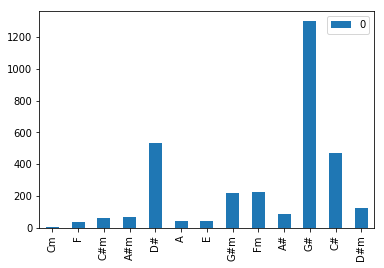

In [6]:
#TEST
testAudio = './test-audio/Disc 1 - 01 - Maple Leaf Rag.flac'

#get tuning --> do we need this anyway?
song_tuning = tuning(testAudio)
print('song tuning: ',song_tuning)

(test, test2, chords, test4) = computeChordsByFrames(testAudio, tuningFrequency=song_tuning)

#chord histogram
chord_counts = Counter(chords)
df = pd.DataFrame.from_dict(chord_counts, orient='index')
df.plot(kind='bar')


In [83]:
'''
Compute Chords by Beats in Essentia

  https://github.com/seffka/ACE2017/blob/467068d9667de43de8b8b8396e620d9e62a0d85c/essentia_chords_beats.py

'''

import sys
import os
from essentia.streaming import *
from essentia.standard import YamlOutput
from essentia.standard import BeatTrackerMultiFeature
from essentia.standard import ChordsDetectionBeats
import numpy as np


def chordBeats(filename, outfile, hopSize=4096, frameSize=8192, tuningFrequency=440.0):
    
    # use pool to store data
    pool = essentia.Pool()
    # initialize algorithms we will use
    loader = MonoLoader(filename=filename)
    framecutter = FrameCutter(hopSize=hopSize, frameSize=frameSize)
    windowing = Windowing(type="blackmanharris62")
    spectrum = Spectrum()
    spectralpeaks = SpectralPeaks(orderBy="magnitude",
                                  magnitudeThreshold=1e-05,
                                  minFrequency=40,
                                  maxFrequency=5000,
                                  maxPeaks=10000)
    hpcp = HPCP(size=12,
                referenceFrequency = tuningFrequency,
                harmonics = 8,
                bandPreset = True,
                minFrequency = 40.0,
                maxFrequency = 5000.0,
                bandSplitFrequency = 500.0,
                weightType = "cosine",
                nonLinear = True,
                windowSize = 1.0)

    # connect algorithms together
    loader.audio >> framecutter.signal
    framecutter.frame >> windowing.frame >> spectrum.frame
    spectrum.spectrum >> spectralpeaks.spectrum
    spectralpeaks.magnitudes >> hpcp.magnitudes
    spectralpeaks.frequencies >> hpcp.frequencies
    hpcp.hpcp >> (pool, 'chroma.hpcp')

    essentia.run(loader)
    
    print('Loading audio file...', filename)
    audio = essentia.standard.MonoLoader(filename = filename)()
    bt = BeatTrackerMultiFeature()
    beats, confidence = bt(audio)
    beats = np.array([round(beat,2) for beat in beats])
    
    #ticks = beats[::4] # TODO: should we take each 4 beats??
    print("number of beats", len(beats))

    chordBeats = ChordsDetectionBeats(hopSize=hopSize)
    chords, strengths = chordBeats(pool['chroma.hpcp'], beats)
    
    segments = toMirexLab(0.0, len(audio) / 44100.0, beats, chords, strengths)
    with open(outfile, 'w') as content_file:
        for s in segments:
            content_file.write(str(s) + '\n')
    
    
    return chords, strengths, beats
    

#essentia_chord_utils.processFiles(infile, outfile, chordBeats)
#chordBeats("test.lab")

'    \n    #name, ext = os.path.splitext(outfile)\n    #YamlOutput(filename=name+\'.chroma.json\')(pool)\n    segments = essentia_chord_utils.toMirexLab(0.0, len(audio) / 44100.0, beats, chords, strengths)\n    with open(outfile, \'w\') as content_file:\n        for s in segments:\n            content_file.write(str(s) + \'\n\')\n            \n    \n\n            \n\ntry:\n    filename = sys.argv[1]\n    outfile = sys.argv[2]\nexcept:\n    print "usage:", sys.argv[0], "<input directory (with audio)> <output lab directory>"\n    sys.exit()\n\n'

Processing audio file... ./test-audio/Disc 1 - 01 - Maple Leaf Rag.flac
song tuning:  442.284
Loading audio file... ./test-audio/Disc 1 - 01 - Maple Leaf Rag.flac
number of beats 300
chords obtained:  299


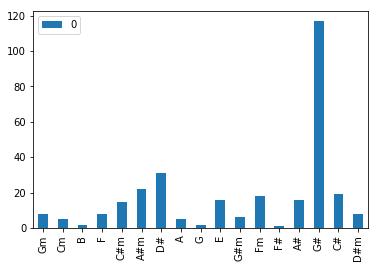

In [84]:
#TEST chordBeats
testAudio = './test-audio/Disc 1 - 01 - Maple Leaf Rag.flac'
reference_lab = "./ref_labs/maple_leaf_rag(hyman).lab"
estimated_chordBeat_lab = "./estimated_chordBeat_labs/test2.lab"

#get tuning --> do we need this anyway?
song_tuning = tuning(testAudio)
print('song tuning: ',song_tuning)



(chords, strengths, beats) = chordBeats(testAudio, estimated_chordBeat_lab, tuningFrequency=song_tuning)

print("chords obtained: " , len(chords))

#chord histogram
chord_counts = Counter(chords)
df = pd.DataFrame.from_dict(chord_counts, orient='index')
df.plot(kind='bar')




In [ ]:
len(beats[::4])

In [85]:
#evaluate with mir_eval

reference_lab = "./ref_labs/maple_leaf_rag(hyman).lab"
fake_test = "./estimated_chordBeat_labs/test_fake.lab"
estimated_chordBeat_lab = "./estimated_chordBeat_labs/test2.lab"

(ref_intervals, 
 ref_labels) = mir_eval.io.load_labeled_intervals(reference_lab)
(est_intervals,
 est_labels) = mir_eval.io.load_labeled_intervals(estimated_chordBeat_lab)



est_intervals, est_labels = mir_eval.util.adjust_intervals(
    est_intervals, est_labels, ref_intervals.min(),
    ref_intervals.max(), mir_eval.chord.NO_CHORD,
    mir_eval.chord.NO_CHORD)

(intervals,
 ref_labels,
 est_labels) = mir_eval.util.merge_labeled_intervals(
    ref_intervals, ref_labels, est_intervals, est_labels)

durations = mir_eval.util.intervals_to_durations(intervals)
comparisons = mir_eval.chord.triads(ref_labels, est_labels)

score = mir_eval.chord.weighted_accuracy(comparisons, durations)

In [86]:
print("durations\n",len(durations), durations)
print("\n comparisons: \n",len(comparisons),comparisons)
print("\n score \n",score)

print(sum(comparisons))


durations
 327 [ 0.44  0.34  0.2   0.29  0.22  0.3   0.21  0.82  0.22  0.28  0.51  0.33
  0.66  0.44  0.07  0.45  0.05  0.46  0.04  0.47  0.04  0.99  1.01  0.04
  0.98  0.04  0.46  0.48  0.05  0.46  0.53  0.98  0.05  1.    0.04  0.47
  0.46  0.04  0.45  0.51  0.5   0.5   0.49  0.49  0.03  0.48  0.51  0.03
  0.51  0.46  0.05  0.45  0.49  0.05  0.47  0.03  0.48  0.03  0.49  0.47
  0.05  1.49  0.51  0.04  0.98  0.04  0.96  0.03  0.46  0.53  0.95  0.05
  0.95  0.04  0.47  0.49  0.03  0.43  0.52  0.49  0.48  0.49  0.51  0.49
  0.51  0.03  1.89  0.04  0.45  0.48  0.47  0.49  0.03  0.47  0.48  0.97
  0.04  0.46  0.48  0.46  0.53  0.45  0.97  0.04  0.45  0.05  0.95  0.05
  0.44  0.48  0.05  0.42  0.04  0.43  0.04  0.96  0.05  0.94  0.49  0.46
  0.05  0.44  0.49  0.46  0.49  0.05  0.45  0.96  0.49  0.04  0.45  1.44
  0.03  0.45  0.48  0.48  0.48  0.04  0.44  0.96  0.05  0.44  0.06  0.92
  0.04  0.93  0.04  0.42  0.05  0.46  1.47  0.45  0.04  0.95  0.05  0.48
  0.47  0.03  0.97  0.03  0.45  0.03

In [ ]:
QUALITIES = {
    #           1     2     3     4  5     6     7
    'maj':     [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
    'min':     [1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0],
    'aug':     [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0],
    'dim':     [1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0],
    'sus4':    [1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0],
    'sus2':    [1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0],
    '7':       [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0],
    'maj7':    [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1],
    'min7':    [1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0],
    'minmaj7': [1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1],
    'maj6':    [1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0],
    'min6':    [1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0],
    'dim7':    [1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0],
    'hdim7':   [1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0],
    'maj9':    [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1],
    'min9':    [1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0],
    '9':       [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0],
    'b9':      [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0],
    '#9':      [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0],
    'min11':   [1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0],
    '11':      [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0],
    '#11':     [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0],
    'maj13':   [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1],
    'min13':   [1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0],
    '13':      [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0],
    'b13':     [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0],
    '1':       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    '5':       [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
    '':        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}